In [ ]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display



### -------- Case study: Personal Savings Planner with IF/ELSE --------

In [8]:
class SavingsState(TypedDict):
    # ---- Inputs ----
    income_usd: float        # monthly income
    expenses_usd: float      # monthly expenses

    # ---- Outputs ----
    savings_usd: float       # monthly savings
    yearly_savings_usd: float
    status: Literal["Surplus", "Deficit"]


In [9]:
# --------- Nodes ---------

def calc_savings(state: SavingsState) -> SavingsState:
    """Node 1: Calculate monthly savings"""
    state["savings_usd"] = state["income_usd"] - state["expenses_usd"]
    return state

def project_yearly(state: SavingsState) -> SavingsState:
    """Node 2: Project yearly savings (only if surplus)"""
    state["yearly_savings_usd"] = state["savings_usd"] * 12
    state["status"] = "Surplus"
    return state

def handle_deficit(state: SavingsState) -> SavingsState:
    """Node 3: Handle case when savings ≤ 0"""
    state["yearly_savings_usd"] = 0.0
    state["status"] = "Deficit"
    return state


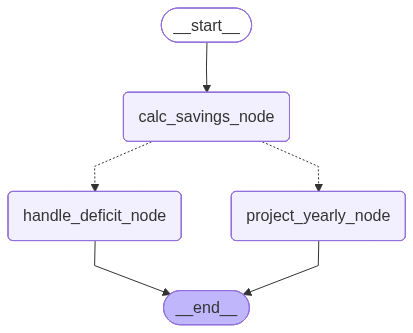

In [10]:
# --------- Build Graph with IF/ELSE Edges ---------
# State = SavingsState
# Nodes = calc_savings_node, project_yearly_node, handle_deficit_node
# Edges = Branching after calc_savings_node based on condition

builder = StateGraph(SavingsState)

# Add nodes
builder.add_node("calc_savings_node", calc_savings)
builder.add_node("project_yearly_node", project_yearly)
builder.add_node("handle_deficit_node", handle_deficit)

# Add edges
builder.add_edge(START, "calc_savings_node")

# Conditional edge: choose based on savings
def decide_next(state: SavingsState):
    return "project_yearly_node" if state["savings_usd"] > 0 else "handle_deficit_node"

builder.add_conditional_edges(
    "calc_savings_node",
    decide_next,   
    {               
        "project_yearly_node": "project_yearly_node",
        "handle_deficit_node": "handle_deficit_node"
    }
)

builder.add_edge("project_yearly_node", END)
builder.add_edge("handle_deficit_node", END)

# Compile graph
graph = builder.compile()

# --------- Visualize Graph ---------
display(Image(graph.get_graph().draw_mermaid_png()))




In [11]:
# --------- Run Examples ---------
# Case 1: Surplus
result1 = graph.invoke({"income_usd": 3000.0, "expenses_usd": 2200.0})
# Case 2: Deficit
result2 = graph.invoke({"income_usd": 2000.0, "expenses_usd": 2500.0})

result1, result2

({'income_usd': 3000.0,
  'expenses_usd': 2200.0,
  'savings_usd': 800.0,
  'yearly_savings_usd': 9600.0,
  'status': 'Surplus'},
 {'income_usd': 2000.0,
  'expenses_usd': 2500.0,
  'savings_usd': -500.0,
  'yearly_savings_usd': 0.0,
  'status': 'Deficit'})

### --------------Another Example------------------

In [13]:


class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    target_currency: Literal["INR", "GBP"]
    converted_money: float

In [14]:
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.10
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['converted_money'] = state['total_usd'] * 85
    return state

def convert_to_gbp(state: PortfolioState) -> PortfolioState:
    state['converted_money'] = state['total_usd'] * 0.74
    return state

def choose_conversion(state: PortfolioState) -> str:
    return state["target_currency"]

In [15]:

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)
builder.add_node("convert_to_gbp_node", convert_to_gbp)

builder.add_edge(START, "calc_total_node")
builder.add_conditional_edges(
    "calc_total_node",
    choose_conversion,
    {
        "INR": "convert_to_inr_node",
        "GBP": "convert_to_gbp_node",
    }
)
builder.add_edge(["convert_to_inr_node", "convert_to_gbp_node"], END)

graph = builder.compile()

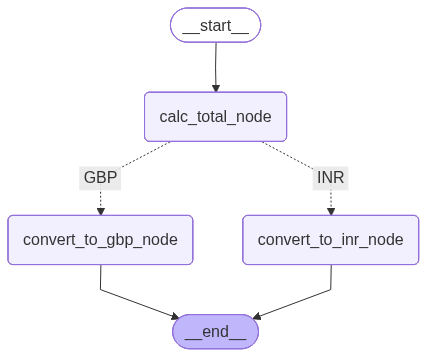

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
graph.invoke({"amount_usd": 1000, "target_currency": "GBP"})

{'amount_usd': 1000,
 'total_usd': 1100.0,
 'target_currency': 'GBP',
 'converted_money': 814.0}